## Carga de librerías


Se han descargado versiones de librerías específicas con el objetivo de garantizar la compatibilidad entre ellas dentro del entorno de desarrollo.

In [ ]:
pip install sklearn.inspection

ERROR: Could not find a version that satisfies the requirement sklearn.inspection (from versions: none)
ERROR: No matching distribution found for sklearn.inspection


In [ ]:
pip install scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
pip install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
pip install bayesian-optimization

In [ ]:
pip install PyALE

In [ ]:
pip install PyCEbox

  Preparing metadata (setup.py) ... done
  Created wheel for PyCEbox: filename=pycebox-0.0.1-py3-none-any.whl size=3624 sha256=b6bc4ad7201b1bd9b2ccad563ac8a481d3c7acfbc2d8ace4158903879974d611
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built PyCEbox


In [ ]:
pip install matplotlib==3.8.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import graphviz
import networkx as nx
from math import sqrt

from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, fbeta_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.tree import DecisionTreeClassifier
from PyALE import ale

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier



# Carga y Preprocesamiento de los datos

Carga de los datos (disponibles en github)

In [ ]:
url = 'https://raw.githubusercontent.com/mariasanmartin/analisis_interpretabilidad/main/german_credit_data.csv'

df = pd.read_csv(url)
df.head()

#Eliminar la primera variable que es equivalente al indice
df = df.iloc[: , 1:]
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Tratamiento valores faltantes

In [ ]:
#Función que calcula los missing values por columna
def missing_values_table(df):
        # Número total de missing values
        mis_val = df.isnull().sum()

        # Porcentaje de missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Dataframe con los resultados
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Renombrar las columnas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Ordenar el dataframe por porcentaje de missing values
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Informar de los resultados
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")


        return mis_val_table_ren_columns

#Información de los missing values del dataframe
missing_values = missing_values_table(df)
missing_values.head(10)

# Eliminar las columnas con más de un 30% de missing values
for columna in missing_values.index:
    if missing_values['% of Total Values'][columna] > 30:
        df = df.drop(columns = columna)

# Para la variable Saving accounts crear una nueva categoría para los missing values
df["Saving accounts"] = df["Saving accounts"].fillna('no_inf')




Your selected dataframe has 10 columns.
There are 2 columns that have missing values.


Comprobación de que todos los datos estén bien detectados

In [ ]:
df.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
count,1000.000000,1000,1000.000000,1000,1000,1000.000000,1000.000000,1000,1000
unique,NaN,2,NaN,3,5,NaN,NaN,8,2
top,NaN,male,NaN,own,little,NaN,NaN,car,good
freq,NaN,690,NaN,713,603,NaN,NaN,337,700
mean,35.546000,NaN,1.904000,NaN,NaN,3271.258000,20.903000,NaN,NaN
std,11.375469,NaN,0.653614,NaN,NaN,2822.736876,12.058814,NaN,NaN
min,19.000000,NaN,0.000000,NaN,NaN,250.000000,4.000000,NaN,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,1365.500000,12.000000,NaN,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,2319.500000,18.000000,NaN,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,3972.250000,24.000000,NaN,NaN


Estudio de correlaciones

<ipython-input-6-4cd9d1775acb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


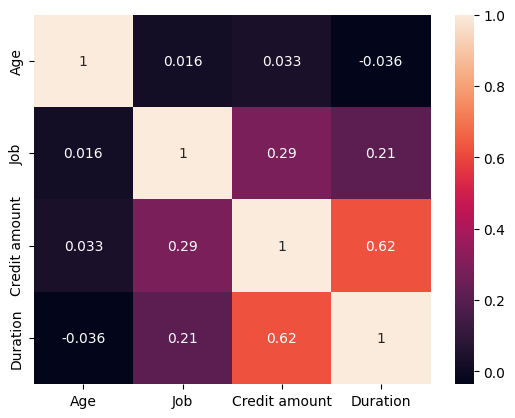

In [ ]:
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

correlaciones = corr_matrix.abs().unstack().reset_index()
correlaciones = correlaciones[~(correlaciones['level_0'] == correlaciones['level_1'])]


One-Hot encoding variables categóricas

In [ ]:
#Identificar variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Convertir columnas categoricas a  dummy variables
dummy_df = pd.get_dummies(df[categorical_columns], drop_first=True)

#Unir las nuevas variables binarias al dataframe original
df = pd.concat([df.drop(columns=categorical_columns), dummy_df], axis=1)



Estudio de correlaciones con las nuevas variables

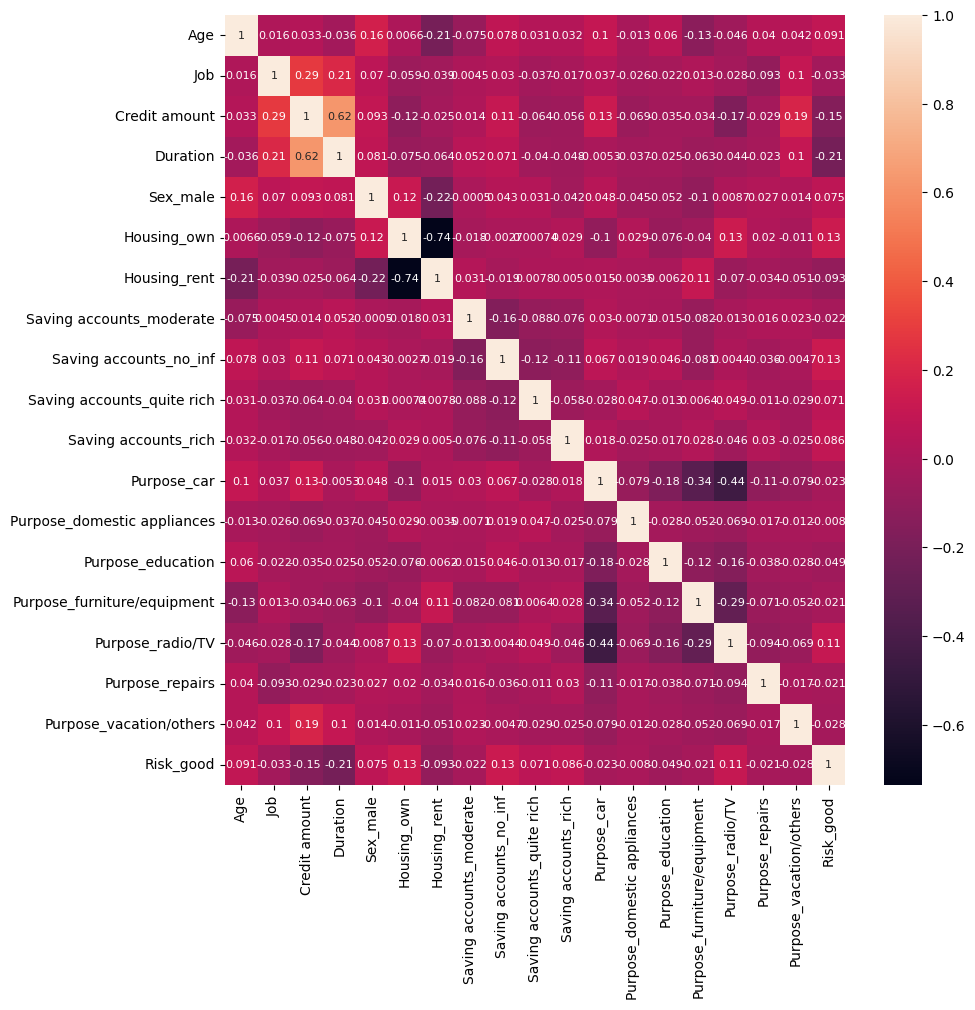

                        level_0                     level_1         0
119                Housing_rent                 Housing_own  0.735968
101                 Housing_own                Housing_rent  0.735968
59                     Duration               Credit amount  0.624984
41                Credit amount                    Duration  0.624984
296            Purpose_radio/TV                 Purpose_car  0.444602
..                          ...                         ...       ...
103                 Housing_own      Saving accounts_no_inf  0.002739
176  Saving accounts_quite rich                 Housing_own  0.000737
104                 Housing_own  Saving accounts_quite rich  0.000737
137    Saving accounts_moderate                    Sex_male  0.000498
83                     Sex_male    Saving accounts_moderate  0.000498

[342 rows x 3 columns]


In [ ]:
corr_matrix = df.corr()
ig, ax = plt.subplots(figsize=(10,10))
sn.heatmap(corr_matrix, annot=True, annot_kws={"size": 8}, ax=ax)
plt.show()

correlaciones = corr_matrix.abs().unstack().reset_index()
correlaciones = correlaciones[~(correlaciones['level_0'] == correlaciones['level_1'])].sort_values(by=0, ascending=False)
print(correlaciones)


Separación de datos de entrenamiento y prueba

In [ ]:
y=df['Risk_good']
X=df.drop(columns=['Risk_good'])
X_desescalado=X #Guardar esta variable para más tarde desescalar

feature_names = X.columns.tolist()

scaler = StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Separacion del train y el test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

## XGBoost Classifier

### Grid Search

In [ ]:

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.05, 0.01, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

# Crear y entrenar el modelo XGBoost
XGB = XGBClassifier(random_state=123)

# Realizar una búsqueda de cuadrícula para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(XGB, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados por GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Entrenar el modelo con los mejores hiperparámetros encontrados
XGB = XGBClassifier(random_state=123, **best_params)
XGB.fit(X_train, y_train)

# Calcular la precisión en el conjunto de prueba
accuracy = XGB.score(X_test, y_test)
print("Accuracy:", accuracy)

# Predecir las etiquetas del conjunto de prueba
y_pred = XGB.predict(X_test)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7266666666666667


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:01:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Entrenar el modelo con los mejores hiperparámetros encontrados
XGB = XGBClassifier(random_state=123,learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=100 )
XGB.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:01:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

#  Análisis de interpretabilidad

### PFI

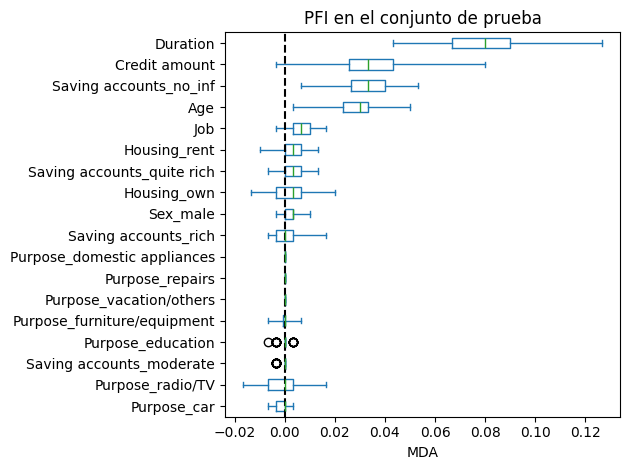

In [ ]:
# Calcula la importancia de permutación de las variables en el conjunto de prueba
result = permutation_importance(
    XGB, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)

# Ordena las importancias y almacena en un DataFrame
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

#Visualización de diagramas de caja de las variables
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("PFI en el conjunto de prueba")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("MDA")
ax.figure.tight_layout()

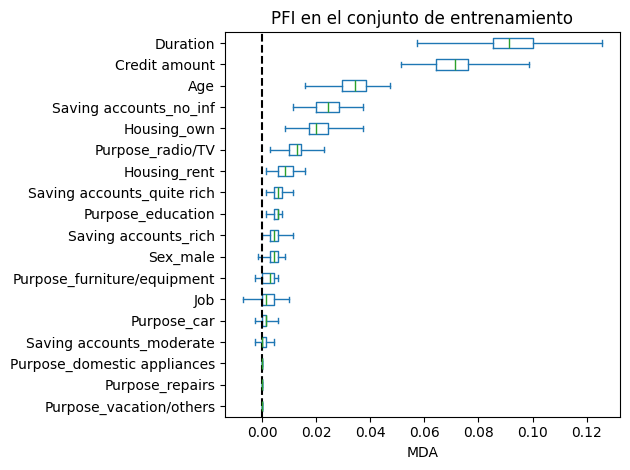

In [ ]:
# Calcula la importancia de permutación de las variables en el conjunto de entrenamiento
result = permutation_importance(
    XGB, X_train, y_train, n_repeats=100, random_state=42, n_jobs=2
)

# Ordena las importancias y almacena en un DataFrame
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

#Visualización de diagramas de caja de las variables
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("PFI en el conjunto de entrenamiento")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("MDA")
ax.figure.tight_layout()

### PDP

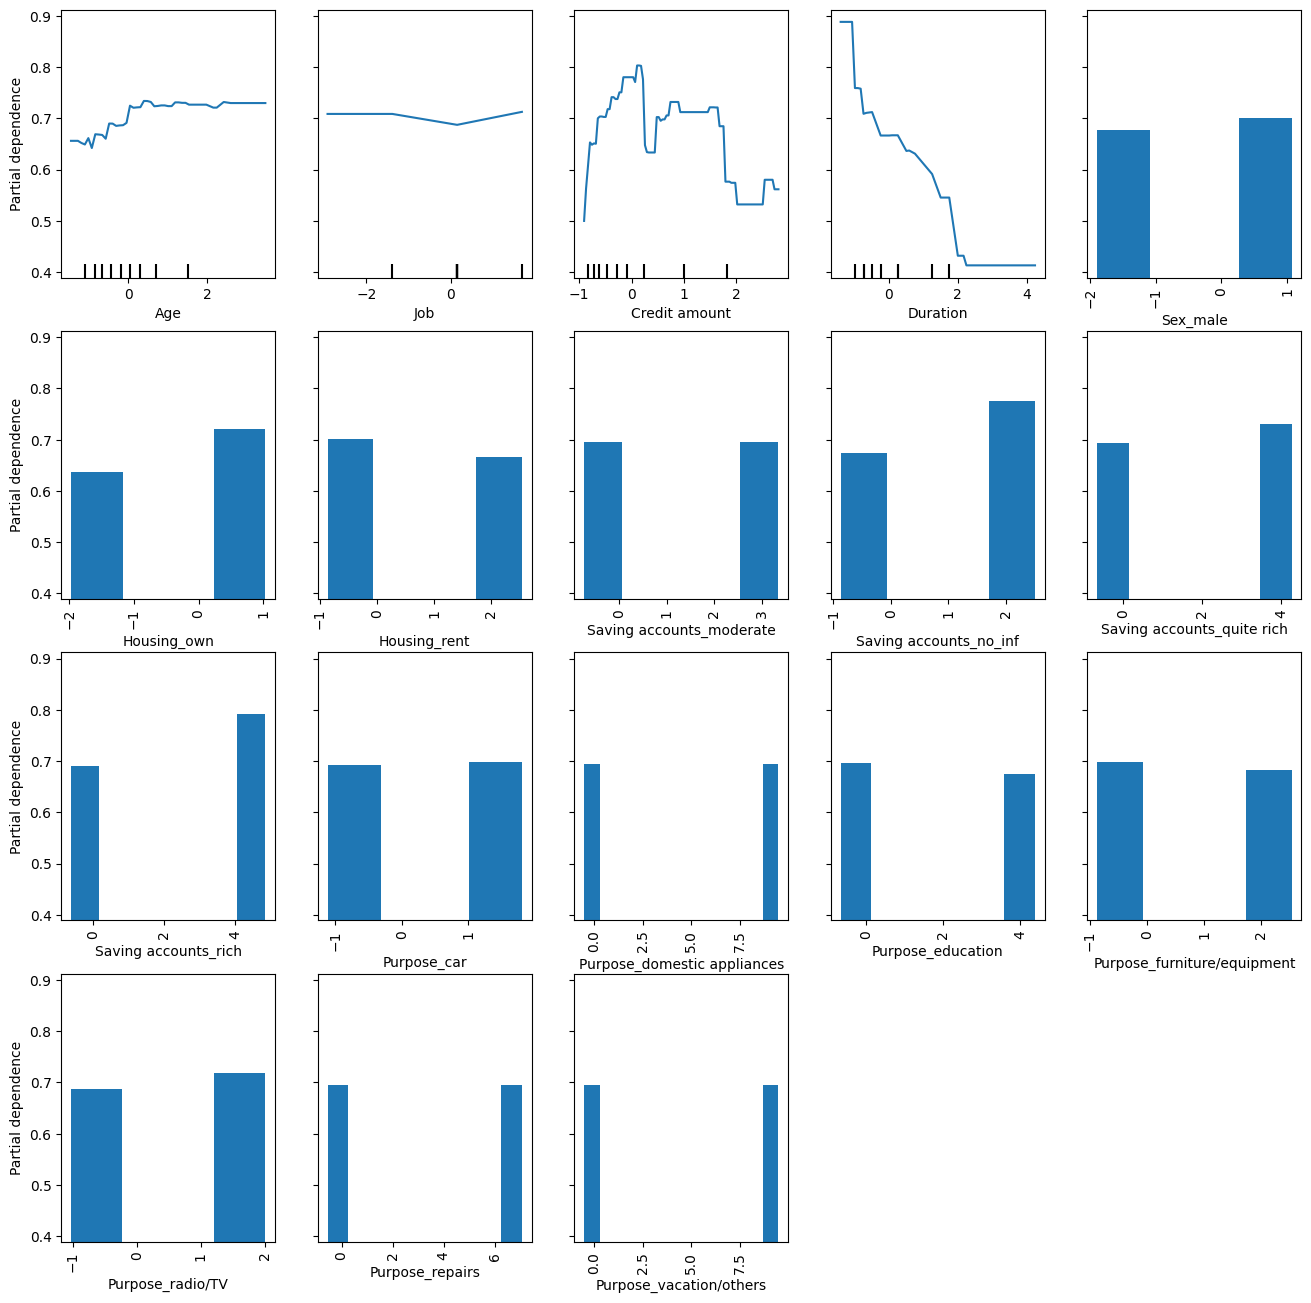

In [ ]:
# Define listas de características numéricas y categóricas
numerical_features = [
    "Duration",
    "Age",
    "Credit amount",
    "Job"
]
categorical_features = list(X_train.columns.drop(numerical_features)) # Excluye las numéricas para obtener las categóricas

# Crea una máscara booleana para las características categóricas
categorical_mask = np.array([feature in categorical_features for feature in X_train.columns])

# Configura un gráfico para mostrar la dependencia parcial de las características
fig, ax = plt.subplots(figsize=(16, 16))
display = PartialDependenceDisplay.from_estimator(
    XGB,
    X_test,
    features=X_train.columns,
    categorical_features=categorical_mask,
    n_cols=5,
    ax=ax,

)

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_aspect('equal')

plt.show()

### ALE

INFO:PyALE._ALE_generic:Continuous feature detected.


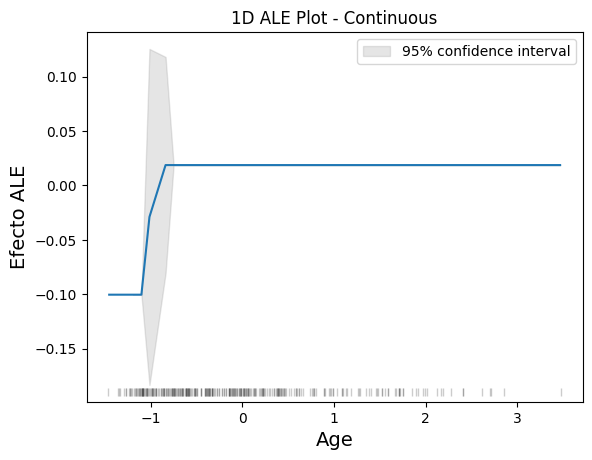

In [ ]:
# Calcular el efecto ALE y Visualización para Age
features=X_test.columns
fig, ax = plt.subplots()
feature_effect = ale(
    X=X_test ,
    model=XGB,
    feature=['Age'],
    ax=ax,
    fig=fig,
    predictors=features
)

# Nombre de los ejes
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Efecto ALE', fontsize=14)

# Mostrar el gráfico
plt.show()

INFO:PyALE._ALE_generic:Continuous feature detected.


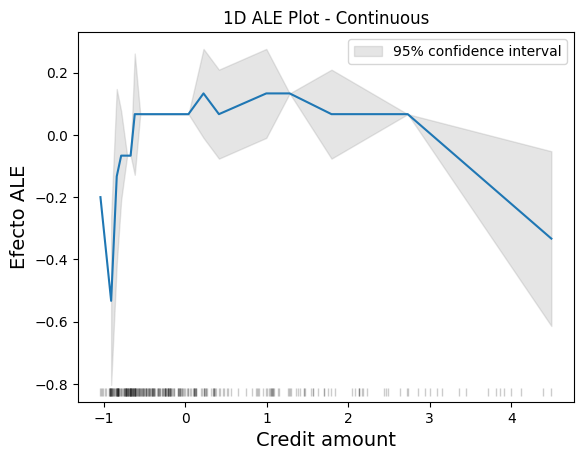

In [ ]:
# Calcular el efecto ALE y Visualización para Credit Amount
fig, ax = plt.subplots()
feature_effect = ale(
    X=X_test ,
    model=XGB,
    feature=['Credit amount'],
    ax=ax,
    fig=fig,
    predictors=features
)

# Nombre de los ejes
ax.set_xlabel('Credit amount', fontsize=14)
ax.set_ylabel('Efecto ALE', fontsize=14)


# Mostrar el gráfico
plt.show()

INFO:PyALE._ALE_generic:Continuous feature detected.


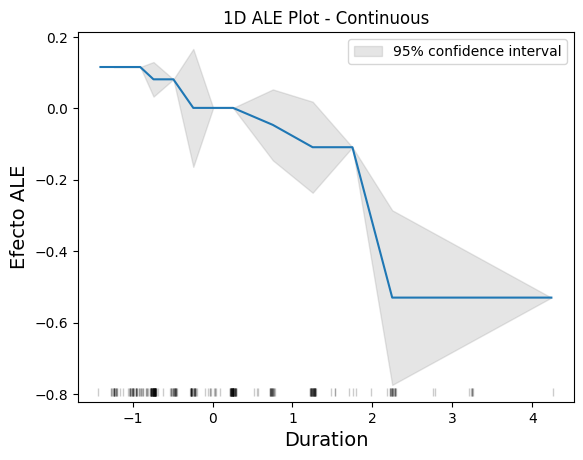

In [ ]:
# Calcular el efecto ALE y Visualización para Duration
fig, ax = plt.subplots()
feature_effect = ale(
    X=X_test ,
    model=XGB,
    feature=['Duration'],
    ax=ax,
    fig=fig,
    predictors=features,
)

# Nombre de los ejes
ax.set_xlabel('Duration', fontsize=14)
ax.set_ylabel('Efecto ALE', fontsize=14)



# Mostrar el gráfico
plt.show()

INFO:PyALE._ALE_generic:Discrete feature detected.


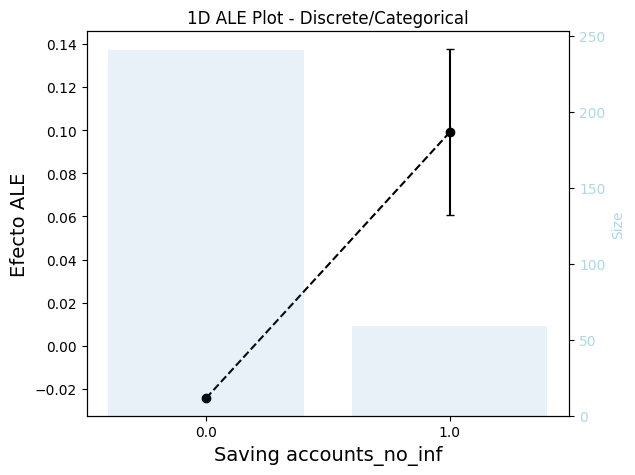

In [ ]:
# Calcular el efecto ALE y Visualización para Saving accounts_no_inf
fig, ax = plt.subplots()
feature_effect = ale(
    X=X_test ,
    model=XGB,
    feature=['Saving accounts_no_inf'],
    ax=ax,
    fig=fig
)

# Nombre de los ejes
ax.set_xlabel('Saving accounts_no_inf', fontsize=14)
ax.set_ylabel('Efecto ALE', fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))


# Mostrar el gráfico
plt.show()

INFO:PyALE._ALE_generic:Discrete feature detected.


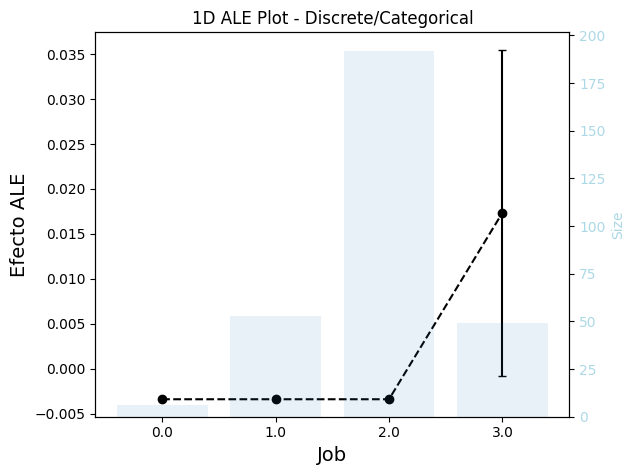

In [ ]:
# Calcular el efecto ALE y Visualización para Job
fig, ax = plt.subplots()
feature_effect = ale(
    X=X_test,
    model=XGB,
    feature=['Job'],
    ax=ax,
    fig=fig)


# Nombre de los ejes
ax.set_xlabel('Job', fontsize=14)
ax.set_ylabel('Efecto ALE', fontsize=14)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))



# Mostrar el gráfico
plt.show()

### MODELO SUBROGADO

#### ÁRBOL DE DECISIÓN

In [ ]:
# Predicciones del modelo de caja negra
y_pred_black_box = XGB.predict(X_train)

#Entrenamiento del modelo
modelo_arbol = DecisionTreeClassifier(max_depth=100, min_samples_leaf=2, criterion='gini', min_samples_split=2 )

# Entrenar el modelo sustituto (modelo de árbol) utilizando las predicciones del modelo de caja negra
modelo_arbol.fit(X_train, y_pred_black_box)

# Hacer predicciones con el modelo de árbol de decisión utilizando el mismo conjunto de datos
y_pred_arbol = modelo_arbol.predict(X_train)

# Calcular el coeficiente de determinación R^2 entre las predicciones de los dos modelos
r2_arbol = r2_score(y_pred_black_box, y_pred_arbol)
print("Coeficiente de determinación R cuadrado (Árbol de decisión):", r2_arbol)



Coeficiente de determinación R cuadrado (Árbol de decisión): 0.7801616555645549


In [ ]:
#Cáculo de las importancias de las características del árbol de decisión
feature_importances = modelo_arbol.feature_importances_

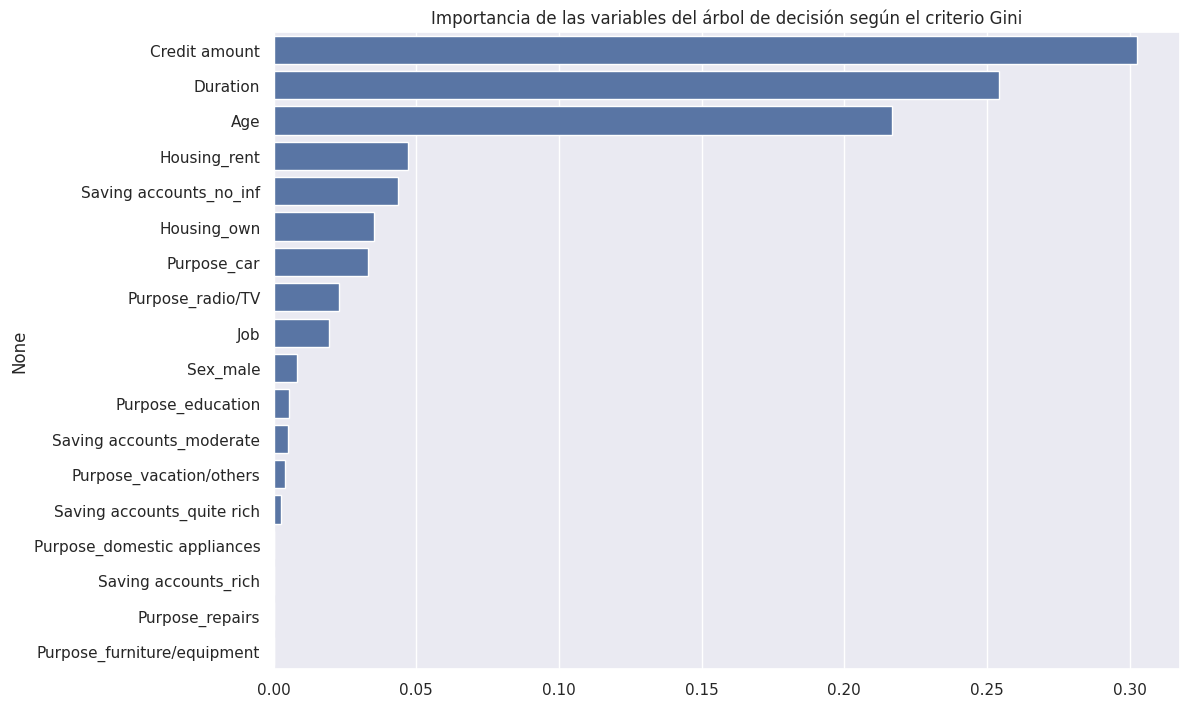

In [ ]:
# Ordenar las importancias de las características de mayor a menor
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Crear un gráfico de barras de las importancias de las características
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)
plt.title('Importancia de las variables del árbol de decisión según el criterio Gini')
plt.show()

In [ ]:
# Plot del árbol de decisión con la librería graphivz
dot_data = tree.export_graphviz(modelo_arbol, out_file=None,
                                feature_names=X_train.columns,
                                class_names=['Risk_bad', 'Risk_good'],
                                filled=True)

#Dibujar el gráfico
graph = graphviz.Source(dot_data, format="png")
graph

#Guardar el árbol de decisión
graph.render("decision_tree_graphivz")


'decision_tree_graphivz.png'

Desescalar variables

In [ ]:
age_values = X_desescalado['Age'].values

scaler = StandardScaler()
age_scaled = scaler.fit_transform(age_values.reshape(-1, 1))

scaled_value = 0.837
descaled_value = scaler.inverse_transform([[scaled_value]])[0][0]
print('De-scaled value:', descaled_value)

De-scaled value: 0.4998658904760679


### PROTOTIPOS


AIX 360 requiere versiones específicas de muchos paquetes de python que entran en conflicto con las herramientas ya utilizadas en este script. Se ha creado un entorno virtual con las dependencias necesarias para la utilización de esta librería. Las dependencias junto con las instrucciones de instalación se pueden encontrar aquí:https://github.com/Trusted-AI/AIX360/tree/master?tab=readme-ov-file.

Este ha sido el código implementado:


In [ ]:
# Importar el explainer Protodash
from aix360.algorithms.protodash import ProtodashExplainer

# Crear una instancia del explainer
explainer = ProtodashExplainer()

# S contiene los índices de los prototipos seleccionados
# W contiene los pesos de importancia asociados con los prototipos seleccionados
datos = X_train.to_numpy()
(W, S, _) = explainer.explain(datos, datos, m=10)

# Mostrar los prototipos junto con sus pesos calculados
X_restaurado = pd.DataFrame(scaler.inverse_transform(X_train), columns=X.columns)
prototipos_incluidos = X_restaurado.iloc[S, :].copy()

# Calcular los pesos de importancia normalizados para los prototipos
prototipos_incluidos["Pesos de los Prototipos"] = np.around(W/np.sum(W), 2)
prototipos_incluidos

ModuleNotFoundError: No module named 'aix360'